# Lecture 10) Bilderkennung mit Convolutional Neural Networks

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor


%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen
import statsmodels.api as sm
import statsmodels.stats.api as sms

#import theano 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from keras.models import Sequential
from keras.layers import InputLayer,Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten

from keras.optimizers import SGD #Stochastic Gradient Descent
from keras.utils.np_utils import to_categorical  
from keras.utils.vis_utils import plot_model

from keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras import applications
from keras_efficientnets import EfficientNetB5

import pathlib
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# updatable plot

from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In der Vorlesung haben wir gesehen, daß Convolutional Neural Networks für die Klassifikation von Bildern optimal sind. Die Kombination von Convolution und Pooling Schichten sorgt dafür, daß mehrdimensionaler Input für die Klassifikationsaufgabe so vorverarbeitet wird, daß relevante Features des Inputs herausgearbeitet werden und redundante Info gefiltert wird.

In keras ist es ganz einfach so ein CNN aufzusetzen.
Es sind dafür genau die layers implementiert, die wir brauchen.

Die conv-layer und die pooling-layer.

Als erstes laden wir einen Datensatz an dem man die Konzepte testen kann.
Der Cifar10-Datensatz ist dafür bestens geeignet.

https://keras.io/api/datasets/cifar10/

Der Datensatz enthält 50.000 Trainingsbilder mit Targets (32x32 Pixel, RGB Color) für 10 zu unterscheidende Klassen:

0   airplane  
1	automobile  
2	bird  
3	cat  
4	deer  
5	dog  
6	frog  
7	horse  
8	ship  
9	truck  

Zum Testen stehen weitere 10.000 Bilder zur Verfügung. 

In [3]:
import pathlib
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
#data_dir = pathlib.Path(data_dir)

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


In [5]:
test_labels

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

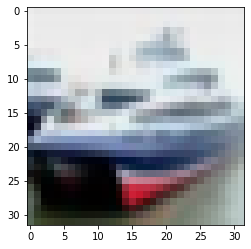

In [6]:
plt.imshow(test_images[1])

Zeichnen wir mal ein paar der Beispiele:

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


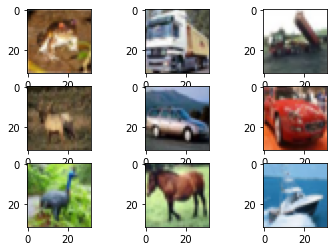

In [7]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (train_images.shape, train_labels.shape))
print('Test: X=%s, y=%s' % (test_images.shape, test_labels.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(train_images[i])
# show the figure
plt.show()

Ma sieht schon, daß es für ein Netz wahrscheinlich nicht ganz einfach sein wird die Klassifikationsaufgabe zu lösen, weil die Bilder nicht besonders hoch aufgelöst sind. Die Aufgabe ist einer der schwierigeren Benchmarks für CNNs.  
Hier kann man mal sehen, wie verschiedene Architekturen bei der Aufgabe abschneiden:  

https://paperswithcode.com/sota/image-classification-on-cifar-10

Mit den neuesten Entwicklungen auf dem Gebiet der Neuronalen Netze (z.B. Transformer) ist aber sogar diese schwierige Aufgabe scheinbar gelöst :-)  

Wir starten aber erstmal mit einem "handgestrickten" ganz einfachen Versuch, also einer minimalen Netzwerkarchitektur.  

Vorher müssen wir aber die Labels noch in einen 1-hot-kodierten Target-Vektor überführen:  

In [8]:
# one hot encode target values
trainY = to_categorical(train_labels)
testY = to_categorical(test_labels)

np.shape(testY)

(10000, 10)

In [9]:
trainY

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

Dann standardisieren wir den Input. Da es sich um Bilder handelt (Intensität ist als Zahl dargestellt: Min=0, Max=255) ist das ganz einfach.
Der Wertebereich der Daten ist nach dem Standardisieren das intervall von 0 bis 1:

In [10]:
# in floats konvertieren
trainX = train_images.astype('float32')
testX = test_images.astype('float32')

# auf einen range von 0-1 normalisieren
trainX = trainX / 255.0
testX = testX / 255.0

### 10.1) Selbstgebastelte CNNs in Keras

Jetzt können wir ein erstes Keras sequential()-Modell mit Conv2D und Pooling Layers aufsetzen.
Die erste Schicht braucht eine Info zur Dimension des Inputs.
Alle anderen Layer werden in ihren Dimensionen automatisch passend konfiguriert.

Nach der abfolge von Convolution und Pooling Schichten wird mit einer Flatten-Layer der Feature-Vektor erzeugt.
Dieser Feature Vektor ist der input für den eigentlichen Klassifikator. Der ist in unserem Fall einfach eine Dense Layer...

In [11]:
#Modell initialisieren
modelCNN_cifar10 = Sequential()

#Modell aufsetzen
modelCNN_cifar10.add(Conv2D(30,                      #Anzahl der Filter
                          kernel_size=(3,3),         #Dimensionen des Fensters
                          strides=(1,1),             #Größe der Schritte
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu',         #Aktivierungsfunktion
                          input_shape=(32,32,3)))    #Dimension des Inputs

modelCNN_cifar10.add(MaxPooling2D(pool_size=(3, 3), #MaxPooling Fenstergröße 3x3
                                  strides=(1,1)))    #Größe der Schritte

modelCNN_cifar10.add(Conv2D(30, kernel_size=(3,3), 
                          strides=(1,1),             #Größe der Schritte
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu'))

modelCNN_cifar10.add(MaxPooling2D(pool_size=(3, 3),
                                  strides=(1,1)))

modelCNN_cifar10.add(Flatten())                       #Feature-Vektor erzeugen
modelCNN_cifar10.add(Dense(100,activation='relu'))
modelCNN_cifar10.add(Dense(10, activation='softmax')) #dicht verschaltete Schicht - lernt Klassifikation!


In [12]:
modelCNN_cifar10.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 30)        840       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 30)        8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 30)        0         
_________________________________________________________________
flatten (Flatten)            (None, 23520)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2352100   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

Im Summary des Modelles kann man gut erkennen, daß selbst dieses kleine CNN richtig viele Parameter hat die gelernt werden müssen. Dementsprechend ist das Training natürlich bedeutend langsamer, als wir das bisher gesehen haben...

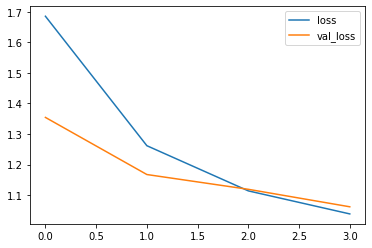

In [13]:
#Modell initialisieren
modelCNN_cifar10 = Sequential()

#Modell aufsetzen
modelCNN_cifar10.add(Conv2D(60,                      #Anzahl der Filter
                          kernel_size=(3,3),         #Dimensionen des Fensters
                          strides=(1,1),             #Größe der Schritte
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu',         #Aktivierungsfunktion
                          input_shape=(32,32,3)))    #Dimension des Inputs

modelCNN_cifar10.add(MaxPooling2D(pool_size=(3, 3), #MaxPooling Fenstergröße 3x3
                                  strides=(1,1)))    #Größe der Schritte

modelCNN_cifar10.add(Conv2D(30, kernel_size=(3,3), 
                          strides=(1,1),             #Größe der Schritte
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu'))

modelCNN_cifar10.add(MaxPooling2D(pool_size=(3, 3),
                                  strides=(1,1)))

modelCNN_cifar10.add(Flatten())                       #Feature-Vektor erzeugen
modelCNN_cifar10.add(Dense(100,activation='relu'))
modelCNN_cifar10.add(Dense(10, activation='softmax')) #dicht verschaltete Schicht - lernt Klassifikation!

#Adam
myAdam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

#RMS Prop
myRMSprop=keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

#Stochastic gradient descent
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) #Parameter beim SGD Lernrate, Momentum, ...

#Modell kompilieren
modelCNN_cifar10.compile(
    optimizer=myAdam, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

#Modell trainieren
historyCNN_cifar10=modelCNN_cifar10.fit(trainX, trainY, 
          validation_data=(testX, testY),                              
          epochs=4,
          batch_size=500,
          verbose=1,
          callbacks=[plot_losses])

In [14]:
modelCNN_cifar10.evaluate(testX, testY)

313/313 [==============================] - 7s 22ms/step - loss: 1.0622 - accuracy: 0.6291


[1.0622444152832031, 0.6291000247001648]

Die accuracy ist nicht wirklich berauschend. Wir haben aber auch ein Mini-Netz am Start :-)  
Die Meta-Parameter sind ja auch noch nicht optimiert...  

Auch über Regularisierung sollte man bei so drastisch überparametrisierten Netzen dringend nachdenken.
Zusätzlich zu den bisher bekannten Maßnahmen (Weight-Decay, Pruning, Ensemble etc.) gibt es dafür eine recht elegante Lösung nämlich den sogenannten Dropout.  

Dabei werden beim Lernen für jeden Durchgang zufällige Konnektoren blockiert.  
Das Netz sieht also für jeden Lernschritt ein kleines bißchen anders aus und man trainiert auf weniger aktiven Parametern.  
Der Dropout wirkt also ein bißchen wie eine Ensemble-Lösung, die nur während des Trainings aktiv ist.  
Die Keras Dropout-Layer läßt sich im sequential-Modell ganz einfach mit einbauen.  
Der Parameter sagt aus, wieviele Gewichte jeweils ausgeschaltet werden sollen (in %):  

modelCNN_cifar10.add(Dropout(0.25))

Zum ersten Mal wurde Dropout von Hinton (2012) diskutiert. Dabei wurden dropout-Layers nach den dense-Layers des Klassifikators eingebaut nicht nach den Conv2D-Schichten.  


https://arxiv.org/pdf/1207.0580.pdf

Später hat sich allerdings gezeigt, daß für komplexe Probleme auch ein moderater Dropout (drop 0.05, 0.1,...) nach Conv2D-Schichten sinnvoll sein kann.  

Hier ein Beispiel mit zwei Dropout-Layers:  

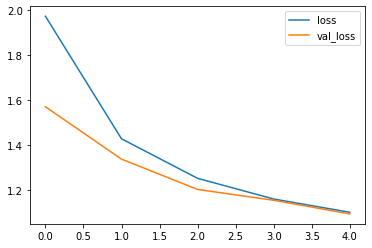

In [15]:
#Modell initialisieren
modelCNN_cifar10 = Sequential()

#Modell aufsetzen
modelCNN_cifar10.add(Conv2D(60,                      #Anzahl der Filter
                          kernel_size=(3,3),         #Dimensionen des Fensters
                          strides=(1,1),             #Größe der Schritte
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu',         #Aktivierungsfunktion
                          input_shape=(32,32,3)))    #Dimension des Inputs

modelCNN_cifar10.add(Dropout(0.05))

modelCNN_cifar10.add(MaxPooling2D(pool_size=(3, 3), #MaxPooling Fenstergröße 3x3
                                  strides=(1,1)))    #Größe der Schritte


modelCNN_cifar10.add(Conv2D(30, kernel_size=(3,3), 
                          strides=(1,1),             #Größe der Schritte
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu'))

modelCNN_cifar10.add(Dropout(0.05))

modelCNN_cifar10.add(MaxPooling2D(pool_size=(3, 3),
                                  strides=(1,1)))


modelCNN_cifar10.add(Flatten())                       #Feature-Vektor erzeugen
modelCNN_cifar10.add(Dense(100,activation='relu'))
modelCNN_cifar10.add(Dense(10, activation='softmax')) #dicht verschaltete Schicht - lernt Klassifikation!

#Adam
myAdam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

#RMS Prop
myRMSprop=keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

#Stochastic gradient descent
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) #Parameter beim SGD Lernrate, Momentum, ...

#Modell kompilieren
modelCNN_cifar10.compile(
    optimizer=myAdam, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

#Modell trainieren
historyCNN_cifar10=modelCNN_cifar10.fit(trainX, trainY, 
          validation_data=(testX, testY),                              
          epochs=5,
          batch_size=500,
          verbose=1,
          callbacks=[plot_losses])

In [16]:
modelCNN_cifar10.evaluate(testX, testY)

313/313 [==============================] - 7s 24ms/step - loss: 1.0919 - accuracy: 0.6161


[1.0919169187545776, 0.616100013256073]

### Aufgabe 1)

Die beiden minimalistischen CNNs von oben sind natürlich noch weit entfernt davon optimal konfiguriert zu sein!

- experimentieren Sie mit den beiden Netzen indem Sie versuchen die Meta-Parameter zu optimieren.
Dazu gehören natürlich die Lernrate, das Lernverfahren sowie typische Parameter wie Anzahl der Hidden-Schichten im Klassifikator und den darin verschalteten Neuronen.
- überlegen Sie, was man noch tun könnte um diese kleinen Netze besser zu machen

### 10.2) Data Augmentation

Besonders bei wenigen Trainingsdaten oder sehr redundanten Samples kann es hilfreich sein sich synthetische Daten aus den gegebenen zu konstruieren.  
Bei Bildern bietet es sich an die gegebenen Beispiele etwas zu rotieren oder zu verschieben und so "neue" Datenpunkte für das Training zu gewinnen.  

In Keras gibt es dafür den ImageDataGenerator.  
Der ist ziemlich klasse, weil er die Originaldaten während des Trainings ändert. Das Modell sieht also während jeder Epoche eine leicht veränderte Version der original Inputs. Man muß keine zusätzlichen Daten abspeichern. Das beschleunigt die Sache enorm!!  

### Rotation

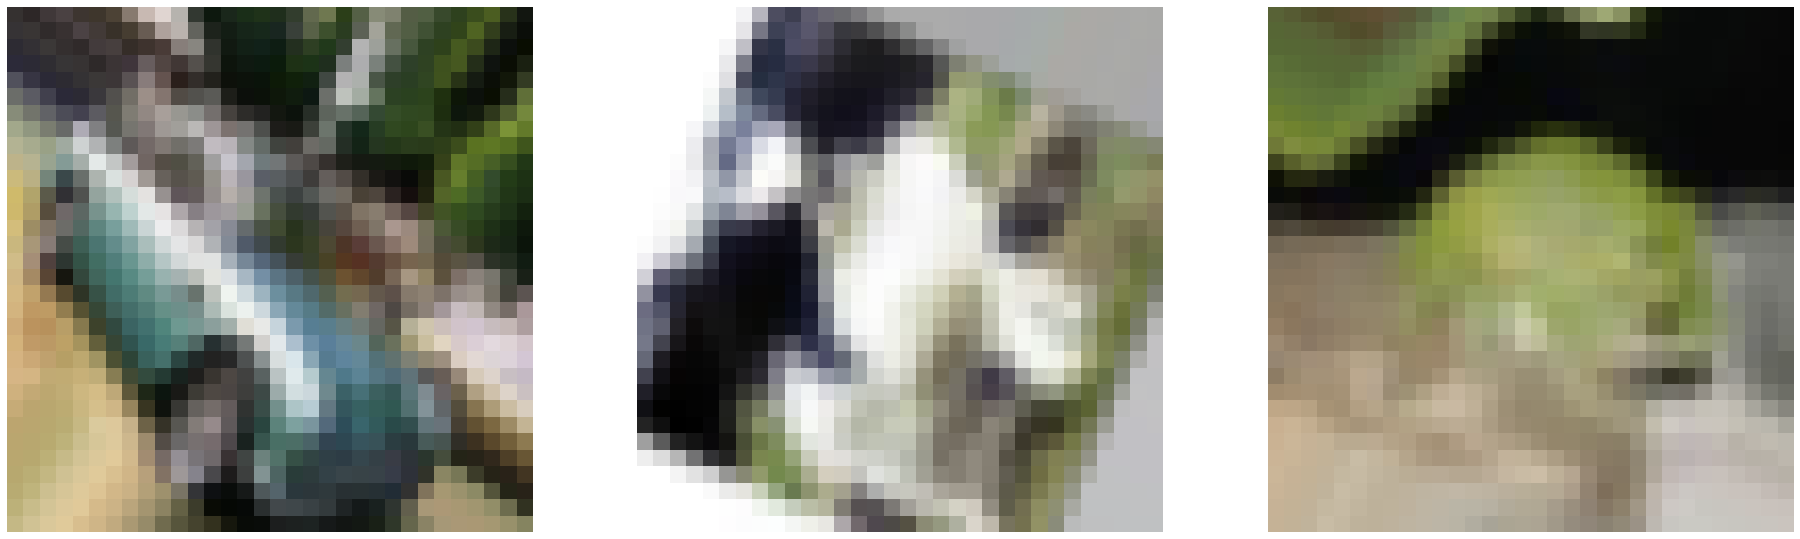

In [17]:
#Image Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator rotation
datagen = ImageDataGenerator(rotation_range=90, fill_mode='nearest')
# iterator
aug_iter = datagen.flow(train_images, batch_size=1)
# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(32,32))
# generate batch of images
for i in range(3):
    # convert to unsigned integers
    image = next(aug_iter)[0].astype('uint8')
    # plot image
    ax[i].imshow(image)
    ax[i].axis('off')

### Flipping

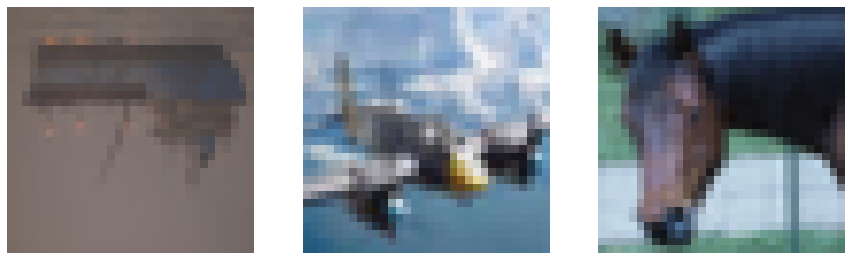

In [18]:
# ImageDataGenerator flipping
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# iterator
aug_iter = datagen.flow(train_images, batch_size=1)
# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
# generate batch of images
for i in range(3):
    # convert to unsigned integers
    image = next(aug_iter)[0].astype('uint8')
    # plot image
    ax[i].imshow(image)
    ax[i].axis('off')

jetzt eine Anwendung für unser Beispiel von vorher:

In [19]:
# ImageDataGenerator definieren

datagen = ImageDataGenerator(
rotation_range=10, # Rotation
width_shift_range=0.2, # horizontaler Shift
height_shift_range=0.2, # vertikaler Shift
zoom_range=0.2, # zoom
horizontal_flip=True) # horizontaler Flip


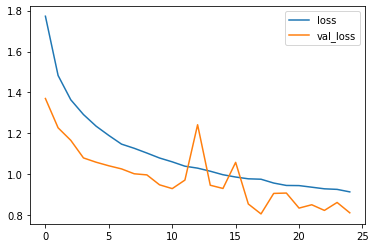

In [20]:
#Modell initialisieren
modelCNN_cifar10 = Sequential()

#Modell aufsetzen
modelCNN_cifar10.add(Conv2D(60,                      #Anzahl der Filter
                          kernel_size=(3,3),         #Dimensionen des Fensters
                          strides=(1,1),             #Größe der Schritte
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu',         #Aktivierungsfunktion
                          input_shape=(32,32,3)))    #Dimension des Inputs

modelCNN_cifar10.add(Dropout(0.05))

modelCNN_cifar10.add(MaxPooling2D(pool_size=(3, 3), #MaxPooling Fenstergröße 3x3
                                  strides=(1,1)))    #Größe der Schritte


modelCNN_cifar10.add(Conv2D(30, kernel_size=(3,3), 
                          strides=(1,1),             #Größe der Schritte
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu'))

modelCNN_cifar10.add(Dropout(0.05))

modelCNN_cifar10.add(MaxPooling2D(pool_size=(3, 3),
                                  strides=(1,1)))


modelCNN_cifar10.add(Flatten())                       #Feature-Vektor erzeugen
modelCNN_cifar10.add(Dense(100,activation='relu'))
modelCNN_cifar10.add(Dense(10, activation='softmax')) #dicht verschaltete Schicht - lernt Klassifikation!

#Adam
myAdam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

#RMS Prop
myRMSprop=keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

#Stochastic gradient descent
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) #Parameter beim SGD Lernrate, Momentum, ...

#Modell kompilieren
modelCNN_cifar10.compile(
    optimizer=sgd, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

#Modell trainieren mit Data Augmentation
historyCNN_cifar10=modelCNN_cifar10.fit_generator(datagen.flow(trainX, trainY, batch_size=100), 
    epochs=25,  # Epochen
    steps_per_epoch=trainX.shape[0]//100,  # Bilder pro Epoche
    validation_data=(testX, testY), # Testdaten
    validation_steps=testX.shape[0]//100,
    verbose=1,
    callbacks=[plot_losses])

In [21]:
modelCNN_cifar10.evaluate(testX, testY)

313/313 [==============================] - 9s 28ms/step - loss: 0.8107 - accuracy: 0.7259


[0.8107025623321533, 0.7258999943733215]

### 10.3) Keras - implementierte Netze benutzen

In Keras sind eine ganze Menge erfolgreicher NN Architekturen verfügbar:

https://keras.io/api/applications/

Die Netze können entweder vortrainiert (also mit bereits angepaßten Gewichten) oder untrainiert geladen und genutzt werden.
Inwiefern es sinnvoll ist Transfer-Learning zu verwenden, also vortrainierte Modelle zu nutzen, hängt von der Aufgabe ab...

verwenden wir einfach mal ein vortrainiertes Netz (Imagenet Daten). In diesem Fall das EfficientNetB5:

https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB5


In [22]:
from tensorflow.python.keras import applications
from keras_efficientnets import EfficientNetB5

In [23]:
trainY.shape[1]

10

In [24]:
#Defining the model
base_model = EfficientNetB5(include_top=False, weights="imagenet", input_shape=(32,32,3),classes=trainY.shape[1])


In [25]:
#Adding the final layers to the above base models where the actual classification is done in the dense layers

model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

#Model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1, 1, 2048)        28513520  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
Total params: 28,513,520
Trainable params: 28,340,784
Non-trainable params: 172,736
_________________________________________________________________


In [26]:
#Adding the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512)) # inputDim = 32x32

model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
#model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(10,activation=('softmax'))) 

#Checking the final model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1, 1, 2048)        28513520  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 10)               

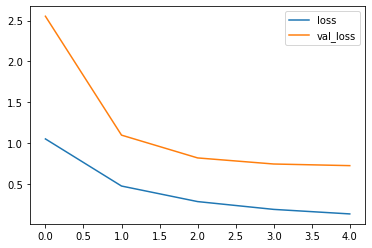

In [27]:
#Compiling the model
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

#Modell kompilieren
model.compile(
    optimizer=myAdam, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

#Modell trainieren
history_model=model.fit(trainX, trainY, 
          validation_data=(testX, testY),                              
          epochs=5,
          batch_size=500,
          verbose=1,
          callbacks=[plot_losses])

In [28]:
model.evaluate(testX, testY)

313/313 [==============================] - 21s 62ms/step - loss: 0.7273 - accuracy: 0.8257


[0.7272791862487793, 0.8256999850273132]